In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt,rotate_rt_ne
from matplotlib.ticker import MultipleLocator
from obspy import read, read_inventory, Stream, Trace, Catalog
import numpy as np
from obspy.io.sac.sacpz import attach_paz
from obspy.signal.filter import envelope
import pandas as pd
import os,glob
import warnings
warnings.filterwarnings("ignore")
model = TauPyModel(model="iasp91")
client = Client("IRIS")
plt.rcParams['font.sans-serif']='Times New Roman'

In [2]:
# eventlist = ['201507070510','201505290700','201505240453','201502271345','201503172212','201502200425',
#             '201412211134','201411150231','201403131706']
eventlist = ['201505240453','20140302201122','20150512211238']
cat = Catalog()
for event in eventlist:
    eve_time = UTCDateTime(event)
    eqevent = client.get_events(starttime=eve_time-5, endtime=eve_time+10*60,minmagnitude =6)
    cat+=eqevent

In [3]:
cat

3 Event(s) in Catalog:
2015-05-24T04:53:23.400000Z | -16.815,  -14.261 | 6.3 MW
2014-03-02T20:11:22.710000Z | +27.424, +127.328 | 6.5 MW
2015-05-12T21:12:58.600000Z | +38.901, +142.022 | 6.8 MW

In [3]:
def checkday(num):
    if len(str(num)) == 1 :
        num = str(0)+str(num)
    return str(num)

In [16]:
network= ['TG','AM']
DATA_DIR = '/Volumes/home/Research/DataBase/00_'
PZ_DIR  =  '/Volumes/home/Research/DataBase/00_PZs'
INFO_DIR = '/Volumes/home/Research/DataBase/Armenia'
CSV_DIR = '/Volumes/home/Research/STEP/00_check_N'
freqmin=0.05#0.05
freqmax=1  #1 
# xmin=0; xmax = 20  ##forS
plotxmin = 20     ##10
plotxmax = +30    ## +10 #for P ##+50 #forS
 xmin=1 ; xmax = 6 ## for P
df = pd.read_csv(INFO_DIR+'/Station_info.csv')

Badstation = ['DDFL','DGRG','LICH','LGD','NAVR','BATM','CANZ','BAUR','GANZ','BKRG','AZMN']
mmm= 5*10**-6
win = 'Pwindow' #'Swindow'

selectionSTA = 'BAUR'

IndentationError: unexpected indent (<ipython-input-16-9071cba2204e>, line 11)

2015-05-24T04:53:23.400000Z
GO ONI exist
BAUR
lagtime=-0.01(s)
/Volumes/home/Research/STEP/00_check_N/Swindow/AM/BAUR


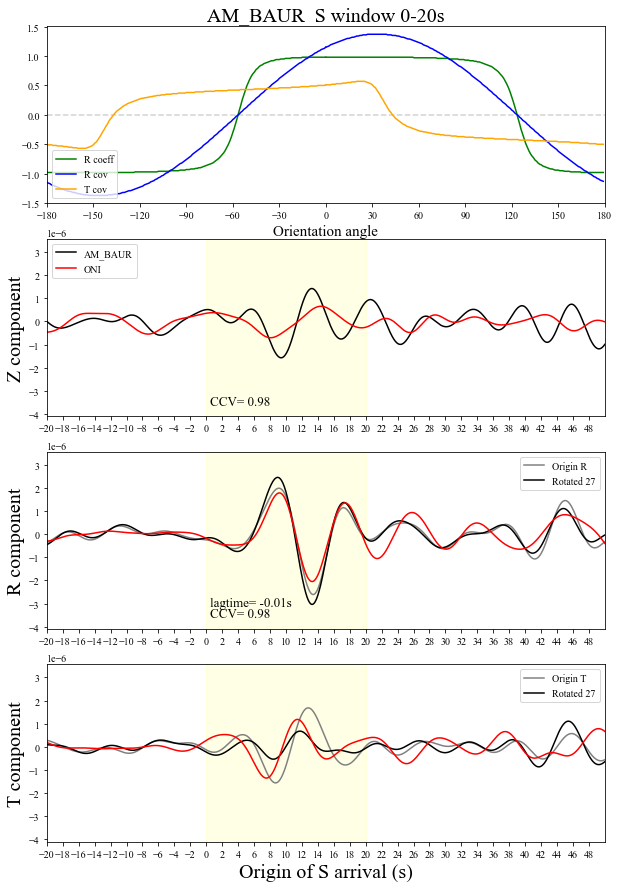

In [19]:
for i in range(0,1):#len(cat)):
    eq_time = cat[i].origins[0].time
    print(eq_time)
    eq_lon = cat[i].origins[0].longitude
    eq_lat = cat[i].origins[0].latitude
    depth  = cat[i].origins[0].depth/1000
    mag    = cat[i].magnitudes[0].mag
    mag_type = cat[i].magnitudes[0].magnitude_type

#     try:
    inv1 = client.get_stations(network="GO", station='ONI', channel="HH?",
                                    starttime=eq_time,endtime=eq_time+30*60)

    ori_st = client.get_waveforms('GO','ONI','*','HH?',eq_time,eq_time+30*60,attach_response=True)
    print('GO ONI exist')
    st = ori_st.copy()
    st.remove_response(pre_filt =  [0.001,0.005,45,50], output="VEL")
    st.detrend('linear')
    st.detrend('demean')
    st.taper(0.05,type='cosine')
    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)


    st_lat = inv1[0][0].latitude
    st_lon = inv1[0][0].longitude
    dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
    deg = kilometer2degrees(dist/1000)
    Arr=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=['P','S'])
    ONI_P_arr = Arr[0].time
    ONI_S_arr = Arr[1].time
    ONI_HHE = st.select(component='E')[0].data
    ONI_HHN = st.select(component='N')[0].data
    ONI_HHZ = st.select(component='Z')[0].data
    ONI_HHR,ONI_HHT = rotate_ne_rt(ONI_HHN,ONI_HHE,baz)

    if win == 'Pwindow':
        ONI_times = st.select(component='E')[0].times(reftime=eq_time+ONI_P_arr)
        xmin_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmin))))[0][0]
        xmax_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmax))))[0][0]
    elif win == 'Swindow':
        ONI_times = st.select(component='E')[0].times(reftime=eq_time+ONI_S_arr)
        xmin_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmin))))[0][0]
        xmax_ind = np.where(ONI_times==min(ONI_times, key=lambda x:abs(x-(xmax))))[0][0]
    ONI_R_window = ONI_HHR[xmin_ind:xmax_ind]
    ONI_T_window = ONI_HHT[xmin_ind:xmax_ind]
    ONI_Z_window = ONI_HHZ[xmin_ind:xmax_ind]

    #####################################################################################
    yyyy = eq_time.year
    mm = checkday(eq_time.month)
    dd = checkday(eq_time.day)
    hh = checkday(eq_time.hour)
    minn = checkday(eq_time.minute)

    deglist = [];STAlist=[]; BAZlist = []
    for net in network:
        NET_DIR = f'{DATA_DIR}{net}'
        NET_PZs = f'{PZ_DIR}/{net}'
        eq_DIR =  f'{NET_DIR}/{yyyy}{mm}{dd}{hh}{minn}'
        if os.path.isdir(eq_DIR):

            for path in sorted(glob.glob(f'{eq_DIR}/*Z')):

                STA = path.rsplit('.',2)[1]

#                 if STA in Badstation:
                if STA == selectionSTA :
                    ori_st = Stream()
                    st_lat = (df['lat'][ (df['network'] == net ) & (df['station'] == STA) ]).item()
                    st_lon = (df['lon'][ (df['network'] == net ) & (df['station'] == STA) ]).item()

                    dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
                    print(STA)
                    dist = dist/1000
                    deg = kilometer2degrees(dist)
                    Arr=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=deg,phase_list=['P','S'])
                    P_arr = Arr[0].time
                    S_arr = Arr[1].time
                    for datapath in glob.glob(f'{eq_DIR}/*{STA}.HH?'):
                            channel = datapath.rsplit('.',1)[-1]
                            tr4pz = Trace()
                            PZs = glob.glob(f'{NET_PZs}/{STA}/*{STA}_{channel}.txt')
                            if PZs == [] and net == 'TG' :
                                PZs = glob.glob(f'{NET_PZs}/ABST/*ABST_{channel}.txt')
                            elif PZs == [] and net == 'AM':
                                PZs = glob.glob(f'{NET_PZs}/ARZA/*ARZA_{channel}.txt')
                            attach_paz(tr4pz,PZs[0],tovel=True)
                            paz = dict(tr4pz.stats.paz)
                            tr = read(datapath,starttime=eq_time, endtime=eq_time+30*60)
                            tr.simulate(paz_remove=paz,pre_filt=(0.033, 0.034, 45, 50))
                            ori_st += tr

                    st = ori_st.copy()
                    st.merge(fill_value=0)
                    st.detrend('linear')
                    st.detrend('demean')
        #             st.taper(0.05,type='cosine')
                    st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)



                    HHE = st.select(component='E')[0].data
                    HHN = st.select(component='N')[0].data
                    HHZ = st.select(component='Z')[0].data
                    if win == 'Pwindow':
                        times = st[0].times(reftime=eq_time+P_arr)
                        xmin_ind = np.where(times==min(times, key=lambda x:abs(x-(xmin))))[0][0]
                        xmax_ind = np.where(times==min(times, key=lambda x:abs(x-(xmax))))[0][0]
                    elif win == 'Swindow':
                        times = st[0].times(reftime=eq_time+S_arr)
                        xmin_ind = np.where(times==min(times, key=lambda x:abs(x-(xmin))))[0][0]
                        xmax_ind = np.where(times==min(times, key=lambda x:abs(x-(xmax))))[0][0]

                    ori_HHR , ori_HHT    = rotate_ne_rt(HHN,HHE,baz)   
                    ori_R_window = ori_HHR[xmin_ind:xmax_ind]
                    ori_T_window = ori_HHT[xmin_ind:xmax_ind]
                    ori_Z_window = HHZ[xmin_ind:xmax_ind]

###==================================================  
                    nx = len(ONI_R_window)
                    lags = np.arange(-nx+1 ,nx)
                    ccov = np.correlate(ONI_R_window - np.mean(ONI_R_window), ori_R_window-np.mean(ori_R_window), mode = 'full')
                    ccor = ccov / ((nx-1)* np.std(ONI_R_window) * np.std(ori_R_window))
                    
                    delta= 0.01
                    ccv_X_Z = lags*delta
                    ccv_Y_Z = ccor
                    for i in range(len(lags)):
                        if abs(ccv_Y_Z[i]) == max(abs(ccv_Y_Z)):
                            ccv_y_Z = ccv_Y_Z[i]
                            ccv_x_Z = lags[i]*delta
                            lagtime = lags[i]
                            lagtime_s = ccv_x_Z       
                    print('lagtime=%s(s)' %(lagtime_s))
                    if abs(lagtime_s) >=4.0 : lagtime_s = 0.0
#                     lagtime_s =0.0
###================================================== correct lagtime  
                    if win == 'Pwindow':
                        times = st[0].times(reftime=eq_time+P_arr-lagtime_s)
                        xmin_ind = np.where(times==min(times, key=lambda x:abs(x-(xmin))))[0][0]
                        xmax_ind = np.where(times==min(times, key=lambda x:abs(x-(xmax))))[0][0]
                    elif win == 'Swindow':
                        times = st[0].times(reftime=eq_time+S_arr-lagtime_s)
                        xmin_ind = np.where(times==min(times, key=lambda x:abs(x-(xmin))))[0][0]
                        xmax_ind = np.where(times==min(times, key=lambda x:abs(x-(xmax))))[0][0]
###==================================================     
                    
                    Rotation = []; R_coefflist = []; R_covlist = []; T_covlist = []; T_coefflist =[]
                    for rot in range(0,361,1):
                        Ang = 360-rot-180
                        if Ang <=0: Ang += 360
                        elif Ang >=360: Ang -=360 

                        rot_N, rot_E = rotate_ne_rt(HHN,HHE,Ang)
                        HHR , HHT    = rotate_ne_rt(rot_N,rot_E,baz)

                        R_window = HHR[xmin_ind:xmax_ind]
                        T_window = HHT[xmin_ind:xmax_ind]
                        Z_window = HHZ[xmin_ind:xmax_ind]
                        R_coeff = np.corrcoef(R_window,ONI_R_window)[0][1]
                        
                        T_coeff = np.corrcoef(T_window,ONI_T_window)[0][1]
                        R_cov  = (np.cov(ONI_R_window,R_window)/np.cov(ONI_R_window))[0][1]
                        T_cov  = (np.cov(ONI_T_window,T_window)/np.cov(ONI_T_window))[0][1]

                        Rotation.append(rot)
                        R_coefflist.append(round(R_coeff,2))
                        T_coefflist.append(round(T_coeff,2))
                        R_covlist.append(round(R_cov,2))
                        T_covlist.append(round(T_cov,2))

                    rot_df = pd.DataFrame({'Rotation': Rotation,
                                           'Rcoeff': R_coefflist,
                                           'Rcov'  : R_covlist,
                                           'Tcov'  : T_covlist })



                    csvpath = f'{CSV_DIR}/{win}/{net}/{STA}'
                    print(csvpath)
#                     if not os.path.isdir(csvpath):
#                         os.makedirs(csvpath)

#                     rot_df.to_csv(f'{csvpath}/{STA}_{yyyy}{mm}{dd}{hh}{minn}_orientation_coeff.csv',index=False)  

                    plt.figure(1,figsize=(10,15))
                    plt.subplot(411)
                    
                    if win == 'Pwindow':
                        plt.title(f'{net}_{STA}  P window {xmin}-{xmax}s',fontsize=20)
                    elif win == 'Swindow':
                        plt.title(f'{net}_{STA}  S window {xmin}-{xmax}s',fontsize=20)
                    plt.hlines(xmin=-180,xmax=180,y=0,linestyle='--',color='lightgrey')
                    plt.plot(Rotation[0:180],R_coefflist[0:180],label='R coeff',c='g')
                    plt.plot(np.array(Rotation[180:])-360,R_coefflist[180:],c='g')
                    plt.plot(Rotation[0:180],R_covlist[0:180],label='R cov',c='b')
                    plt.plot(np.array(Rotation[180:])-360,R_covlist[180:],c='b')            
                    plt.xlim(-180,180)
                    plt.xticks(np.arange(-180, 180+1, 30))
                    plt.xlabel('Orientation angle',fontsize=15)
                    plt.plot(Rotation[0:180],T_coefflist[0:180],label='T cov',c='orange')
                    plt.plot(np.array(Rotation[180:])-360,T_coefflist[180:],c='orange')
                    plt.legend(loc='lower left')
        ####=========================plot waveform with ONI 
                    plt.subplot(412)
                    plt.fill_between(x=[xmin,xmax],y1=-10**-4,y2=10**-4,color = 'yellow', alpha = 0.1)
                    plt.plot(times,HHZ,'k',label=f'{net}_{STA}')
                    plt.xlim(xmin-plotxmin,xmax+plotxmax)
                    plt.subplot(413)
                    plt.fill_between(x=[xmin,xmax],y1=-10**-4,y2=10**-4,color = 'yellow', alpha = 0.1)
                    plt.plot(times,ori_HHR,'grey',label='Origin R')
                    plt.subplot(414)
                    plt.fill_between(x=[xmin,xmax],y1=-10**-4,y2=10**-4,color = 'yellow', alpha = 0.1)
                    plt.plot(times,ori_HHT,'grey',label='Origin T')
                    max_coeff = max(R_covlist)
                    find_df = rot_df[rot_df['Rcov']== max_coeff]
                    if win == 'Pwindow':
                        angle   = find_df['Rotation'][find_df['Tcov'] == min(find_df['Tcov'])]
                        T_coeff = min(find_df['Tcov'])
                    elif win == 'Swindow':
                        angle   = find_df['Rotation'][find_df['Tcov'] == max(find_df['Tcov'])]
                        T_coeff = max(find_df['Tcov'])
                    for ang in angle:
                        if ang != 360 :
                            Ang = 360-ang-180
                            if Ang <=0: Ang += 360
                            elif Ang >=360: Ang -=360 

                            rot_N, rot_E = rotate_ne_rt(HHN,HHE,Ang)
                            rot_HHR , rot_HHT    = rotate_ne_rt(rot_N,rot_E,baz)
                            
                            R_window = rot_HHR[xmin_ind:xmax_ind]
                            R_coeff = np.corrcoef(R_window,ONI_R_window)[0][1] 
                            
                            plt.subplot(413)
                            plt.plot(times,rot_HHR,'k',label=f'Rotated {ang}')      
                            plt.legend(loc='upper right')
                            plt.subplot(414)
                            plt.plot(times,rot_HHT,'k',label=f'Rotated {ang}') 
                            plt.legend(loc='upper right')
                    if win == 'Pwindow':
                        ymin=min(min(ONI_HHR),min(ONI_HHT),min(ONI_HHZ))*1.3;ymax=max(max(ONI_HHT),max(ONI_HHR),max(ONI_HHZ))*1.3
                    elif win == 'Swindow':
                        ymin=min(min(ONI_R_window),min(ONI_T_window),min(ONI_Z_window))*2;ymax=max(max(ONI_T_window),max(ONI_R_window),max(ONI_Z_window))*2
                    
                    plt.subplot(412)
                    plt.plot(ONI_times,ONI_HHZ,'r',label='ONI')
                    if win == 'Pwindow':
                        plt.text(xmin+0.5,ymin+0.3*10**-5,f'CCV= {round(max(abs(ccv_Y_Z)),2)}',fontsize=13)
                    elif win == 'Swindow':
                        plt.text(xmin+0.5,ymin+0.5*10**-6,f'CCV= {round(max(abs(ccv_Y_Z)),2)}',fontsize=13)
                        
                    plt.xlim(xmin-plotxmin,xmax+plotxmax)
                    plt.ylim(ymin,ymax)
                    plt.xticks(np.arange(xmin-plotxmin, xmax+plotxmax, 2))
                    plt.legend(loc='upper left')
                    plt.ylabel('Z component', fontsize=20)
                    plt.subplot(413)
                    plt.plot(ONI_times,ONI_HHR,'r')
                    plt.xlim(xmin-plotxmin,xmax+plotxmax)
                    plt.ylim(ymin,ymax)
                    plt.xticks(np.arange(xmin-plotxmin, xmax+plotxmax, 2))
                    if win =='Pwindow':
                        plt.text(xmin+0.5,ymin+0.3*10**-5,f'CCV= {round(R_coeff,2)}',fontsize=13)
                        plt.text(xmin+0.5,ymin+0.6*10**-5,f'lagtime= {round(lagtime_s,2)}s',fontsize=13)
                    elif win == 'Swindow':
                        plt.text(xmin+0.5,ymin+1*10**-6,f'lagtime= {round(lagtime_s,2)}s',fontsize=13)
                        plt.text(xmin+0.5,ymin+0.5*10**-6,f'CCV= {round(R_coeff,2)}',fontsize=13)
                    plt.ylabel('R component', fontsize=20)
                    plt.subplot(414)
                    plt.plot(ONI_times,ONI_HHT,'r')
                    plt.xlim(xmin-plotxmin,xmax+plotxmax)
                    plt.ylim(ymin,ymax)
                    plt.xticks(np.arange(xmin-plotxmin, xmax+plotxmax, 2))
                    plt.ylabel('T component', fontsize=20)
                    if win == 'Pwindow':
                        plt.xlabel('Origin of P arrival (s)', fontsize=20)
                    elif win == 'Swindow':
                        plt.xlabel('Origin of S arrival (s)', fontsize=20)
                    plt.show()
#                     plt.savefig(f'{csvpath}/{STA}_{yyyy}{mm}{dd}{hh}{minn}_orientation_waveform.pdf')
#                     plt.close()
#     except: print('No data')

5
10
15
20
25
30
30
25
20
15
10
5


Text(0.5, 0.98, 'DMNI Swindow b.p. 0.05-0.2Hz')

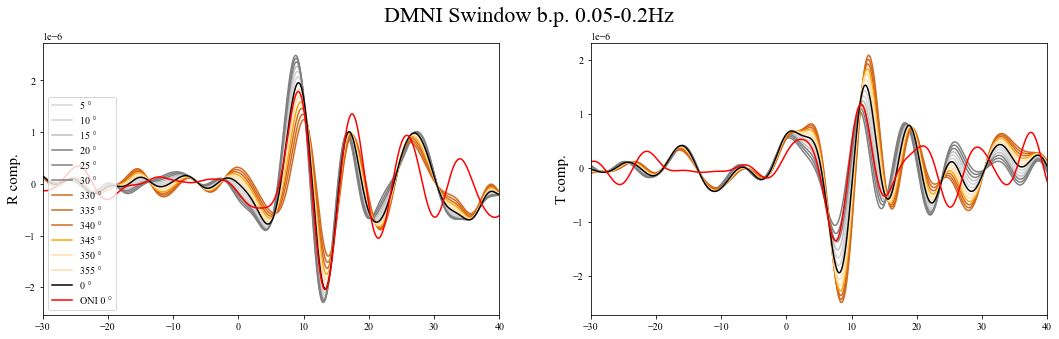

In [38]:
fig= plt.figure(figsize=(18,5))

symbol = u"\N{DEGREE SIGN}"
for ang in range(0,30+1,5):
    if ang !=0:
        Ang = 360-ang-180
        if Ang <=0: Ang += 360
        elif Ang >=360: Ang -=360 
        rot_N, rot_E = rotate_ne_rt(HHN,HHE,Ang)
        rot_HHR , rot_HHT    = rotate_ne_rt(rot_N,rot_E,baz) 
        ppAng = abs(Ang-180)
        print(ppAng)
        if ppAng  <=10: c = 'lightgrey'
        elif ppAng  == 15 : c = 'silver'
        elif ppAng  >= 20 : c = 'grey'
        plt.subplot(121)
        plt.plot(times,rot_HHR,color = c,label = f'{ang} {symbol}')
        plt.subplot(122)
        plt.plot(times,rot_HHT,color = c)
for ang in range(330,355+1,5):
    if ang !=0:
        Ang = 360-ang-180
        if Ang <=0: Ang += 360
        elif Ang >=360: Ang -=360 
        rot_N, rot_E = rotate_ne_rt(HHN,HHE,Ang)
        rot_HHR , rot_HHT    = rotate_ne_rt(rot_N,rot_E,baz) 
        ppAng = abs(Ang-180)
        print(ppAng)
        if ppAng  <=10: c = 'navajowhite'
        elif ppAng  == 15 : c = 'orange'
        elif ppAng  >= 20 : c = 'chocolate'
        plt.subplot(121)
        plt.plot(times,rot_HHR,color = c,label = f'{ang} {symbol}')
        plt.subplot(122)
        plt.plot(times,rot_HHT,color = c)
plt.subplot(121)
plt.plot(times,ori_HHR,'k',label=f'0 {symbol}')        
plt.plot(ONI_times,ONI_HHR,'r',label=f'ONI 0 {symbol}')
plt.legend(loc = 3)
plt.ylabel('R comp.',fontsize=15)
plt.xlim(-30,40)
plt.subplot(122)
plt.plot(times,ori_HHT,'k',label=f'0 {symbol}')  

plt.plot(ONI_times,ONI_HHT,'r')
plt.xlim(-30,40)
plt.ylabel('T comp.',fontsize=15)
plt.suptitle(f'{selectionSTA} {win} b.p. {freqmin}-{freqmax}Hz',fontsize=22)

In [12]:
from obspy.signal.polarization import particle_motion_odr

(-3e-06, 3e-06)

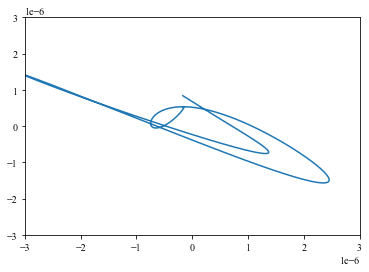

In [25]:
plt.plot(R_window,Z_window)
plt.xlim(-3*10**-6,3*10**-6)
plt.ylim(-3*10**-6,3*10**-6)

In [23]:
baz

236.03067099111934

(-3e-06, 3e-06)

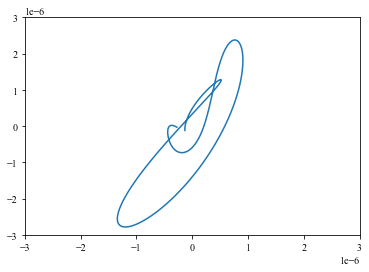

In [26]:
plt.plot(HHE[xmin_ind:xmax_ind],HHN[xmin_ind:xmax_ind])
plt.xlim(-3*10**-6,3*10**-6)
plt.ylim(-3*10**-6,3*10**-6)